Carga de paquetes (y en el colab meter la imagen, habrá que quitar lo del google colab)

In [6]:
import cv2 
#import easyocr #OCR que igual ni usamos
import pytesseract  # El ocr bueno
import matplotlib.pyplot as plt
import shutil
import os
import random
import numpy as np
import pywt
import pywt.data
from scipy.ndimage import rotate
try:
 from PIL import Image
except ImportError:
 import Image
 
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Adjust the path based on your installation location
#reader = easyocr.Reader(['hi','en'])


In [7]:

# Load image
original = Image.open("data\images\WhatsApp Image 2023-11-19 at 17.21.41.jpeg")

In [8]:
grayscale_original = original.convert("L")
LL = np.array(grayscale_original)
alt, anch = LL.shape
print(alt, anch)

2016 1512


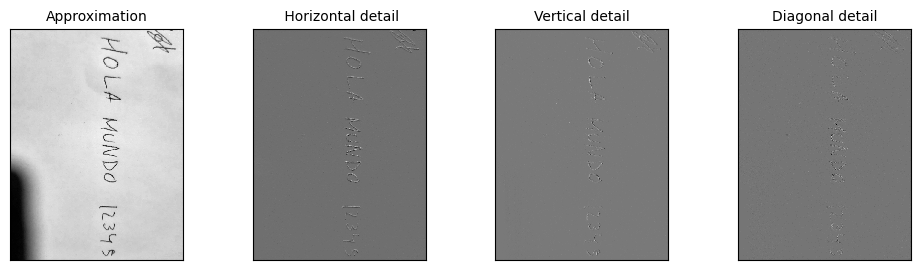

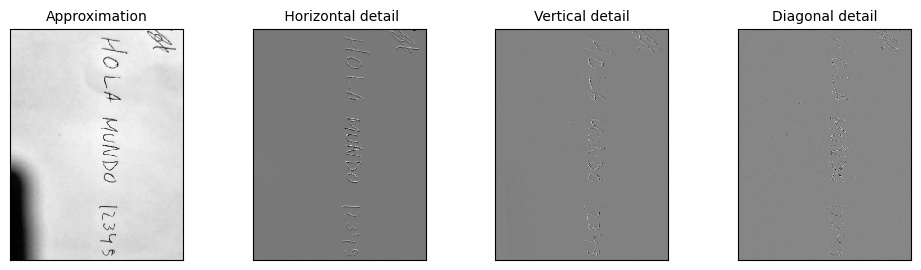

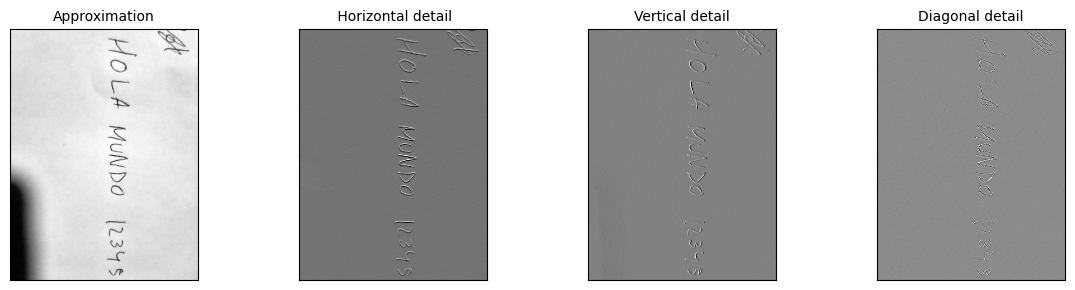

In [9]:

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
num_it = 3
for j in range(0, num_it):
    coeffs2 = pywt.dwt2(LL, "haar")
    LL, (LH, HL, HH) = coeffs2
    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()
plt.show()

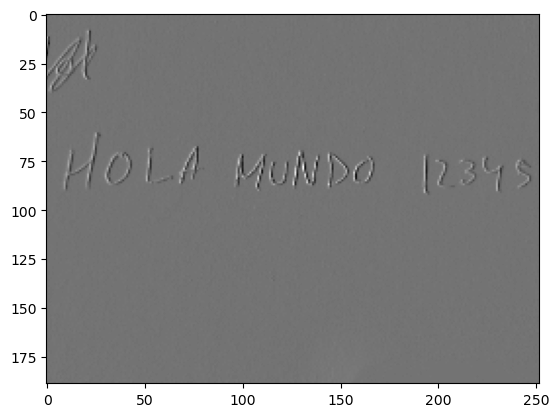

In [11]:
#cojo HH porque he escrito sobre una libreta de cuadritos y así me quito las líneas, lo suyo sería escribir sobre blanco y pillar HL o LH
HHR = rotate(LH, 90, reshape = True) #rota la imagen (opcional)
plt.imshow(HHR, cmap='gray')
plt.show()

imagen_OCR = HHR.copy()

In [12]:
print(imagen_OCR.shape)

(189, 252)


ocr easyocr para detectar texto directamente (mejor):

ocr pytesseract para sacar imagenes letra a letra:

In [36]:
bit_8 = cv2.convertScaleAbs(imagen_OCR)
edged_image = cv2.Canny(bit_8, threshold1=10, threshold2=100)  # Ajusta los valores de umbral según tu imagen
cv2.imshow('Filtered Image', bit_8)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [39]:

# Encuentra los contornos en la imagen de bordes
contours, _ = cv2.findContours(edged_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Recorrer los contornos identificados
for i,contour in enumerate(contours):
    # Obtener las coordenadas y dimensiones de cada contorno
    x, y, w, h = cv2.boundingRect(contour)

    # Recortar la región con la letra
    letter_region = edged_image[y:y+h, x:x+w]

    # Aplicar OCR para reconocimiento de texto en la región
    text = pytesseract.image_to_string(letter_region, lang='eng')

    # Guardar la imagen de la letra y el texto reconocido
    cv2.imwrite(f'data\images\letra_{i}.png'.format(text), letter_region)

''

ocr easyocr para sacar imagenes letra a letra:

In [21]:
#cambia el tamaño
imagen = cv2.imread("data\images\letra_16.png")
imagen = cv2.resize(imagen, (28, 28))
ancho, alto, can = imagen.shape
cv2.imwrite(f'data\images\letra_O.png', imagen)
print(alto, ancho)


28 28
